In [1]:
import pandas as pd
import os
import numpy as np
import json

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import RFE,RFECV,SelectKBest
from sklearn.preprocessing import scale, robust_scale, minmax_scale
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score as acc
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

from cycifsuite.feature_selection import *
from cycifsuite.get_data import read_synapse_file

## Get plate 6 raw data by ligands from imstore, this only needs to be run once

In [2]:
if not os.path.exists('d:/data/MCF10A 090718 data/feature_evaluation/plate_6_txt_features_TGFB.hdf'):
    pooled_metadata = pd.read_csv(read_synapse_file('syn17902177'),index_col=0)
    valid_cells = pooled_metadata[(pooled_metadata.labeled_as_lost=='No')&(pooled_metadata.num_nuclei_in_mask==1)&(pooled_metadata.Plate==6)].index
    plate_6 = pooled_metadata[pooled_metadata.Plate==6][['ligand','Well']].drop_duplicates()
    for ligand_group in plate_6.groupby('ligand'):
        ligand_pool = pd.DataFrame()
        ligand, wells = ligand_group
        wells = wells.Well.values
        for well in wells:
            for fld in ['fld' + str(i) for i in range(1,9)]:
                fn = '_'.join((well, fld, 'allFeatures.txt'))
                print(fn)
                try:
                    _df = pd.read_csv(fn, sep='\t')
                except:
                    continue
                cell_name_prefix = '_'.join(('6_cell', well, fld))
                _df.index = [cell_name_prefix + '_' + str(x+1) for x in _df.index]
                _df = _df.loc[[x for x in _df.index if x in valid_cells]]
                ligand_pool = ligand_pool.append(_df)
        ligand_pool.to_hdf('d:/data/MCF10A 090718 data/feature_evaluation/plate_6_txt_features_{}.hdf'.format(ligand), ligand)
        

## Read data in a seperate .hdf file per ligand

In [3]:
pooled_metadata = pd.read_csv(read_synapse_file('syn17902177'),index_col=0)
path = 'd:/data/MCF10A 090718 data/feature_evaluation/'
feature_files = [x for x in os.listdir(path) if '.hdf' in x]
sample_size=None
with open('d:/data/MCF10A 090718 data/feature_metadata.json') as f:
    data=json.load(f)
feature_meta = pd.DataFrame.from_dict(data).transpose()
feature_meta = feature_meta.loc[[x for x in feature_meta.index if 'cellpos' not in x]]
os.chdir('d:/data/MCF10A 090718 data/feature_evaluation')
print(feature_files)

Welcome, Yunguan Wang!

['plate_6_txt_features_BMP2.hdf', 'plate_6_txt_features_EGF.hdf', 'plate_6_txt_features_HGF.hdf', 'plate_6_txt_features_IFNG.hdf', 'plate_6_txt_features_OSM.hdf', 'plate_6_txt_features_PBS.hdf', 'plate_6_txt_features_TGFB.hdf']


# Read and bin the data well-wise
#### **Note: Scaling for PCA**
PCA to test if the centroids are separable in various feature spaces.
#### Figure 2

In [4]:
x_binned, y_binned = make_x_and_y(path, feature_files, binning=True, metadata=pooled_metadata)
plot_binned_pca_plot(x_binned, y_binned, figsize=(8,5), figname='PCA 2D scatter all features.png')
plot_feature_wise_pca(x_binned, y_binned,  feature_meta, figsize=(8,5), save_fig_prefix='p6')

processing plate_6_txt_features_BMP2.hdf
processing plate_6_txt_features_EGF.hdf
processing plate_6_txt_features_HGF.hdf
processing plate_6_txt_features_IFNG.hdf
processing plate_6_txt_features_OSM.hdf
processing plate_6_txt_features_PBS.hdf
processing plate_6_txt_features_TGFB.hdf


## Evaluate full model and models with different cat of features

In [5]:
x_train, x_test, y_train, y_test = make_x_and_y(path, feature_files,sample_size=sample_size, test_size=0.20)
full_model = RandomForestClassifier(100)
full_model.fit(x_train, y_train)
y_pred = full_model.predict(x_test)
print('Full feature accuracy {}'.format(acc(y_test, y_pred)))

processing plate_6_txt_features_BMP2.hdf
processing plate_6_txt_features_EGF.hdf
processing plate_6_txt_features_HGF.hdf
processing plate_6_txt_features_IFNG.hdf
processing plate_6_txt_features_OSM.hdf
processing plate_6_txt_features_PBS.hdf
processing plate_6_txt_features_TGFB.hdf
Full feature accuracy 0.9703435609334485


In [6]:
"""Define sets of features
"""
feature_sets = pd.Series()
for feature_set_name in feature_meta.feature_cat.unique():
    feature_list = feature_meta[feature_meta.feature_cat==feature_set_name].index.tolist()
    feature_sets[feature_set_name] = feature_list
# old_int features
feature_list = [k for k in x_train.columns if '_int_' in k]    
feature_list = [k for k in feature_list if k.split('_')[-1] in ['nuc','cyto']]
feature_sets['old_int'] = feature_list
# mean, standev
feature_list = feature_meta[feature_meta.feature_type.isin(['mean','standev'])].index.tolist()
feature_sets['mean+sd'] = feature_list
feature_sets['all'] = feature_meta.index.tolist()

CV accurary with feature category int with 360 features : 0.95
CV accurary with feature category txt with 3595 features : 0.96
CV accurary with feature category mor with 4 features : 0.21
CV accurary with feature category old_int with 72 features : 0.92
CV accurary with feature category mean+sd with 360 features : 0.97
CV accurary with feature category all with 3959 features : 0.97


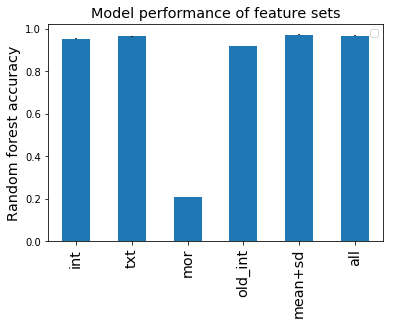

In [7]:
cat_model = RandomForestClassifier(100)
model_stats = pd.DataFrame()
for i in feature_sets.index:
    feature_list = feature_sets[i]
    feature_list = [x for x in feature_list if x in x_train.columns]
    rf_cv = cross_val_score(cat_model, x_train[feature_list], y_train,scoring='accuracy', cv=5,n_jobs=4)
    model_stats.loc['mean',i] = rf_cv.mean()
    model_stats.loc['sd',i] = rf_cv.std()
    print('CV accurary with feature category {} with {} features : {:.2f}'.format(i, len(feature_list), rf_cv.mean()))
# plotting
model_stats.transpose().plot(kind='bar',yerr='sd')
plt.ylabel('Random forest accuracy', fontsize='x-large')
plt.xticks(fontsize='x-large')
plt.title('Model performance of feature sets',fontsize='x-large')
plt.legend('')
plt.tight_layout
plt.savefig('Model performance of feature sets.png')

In [8]:
# Evaluate feature importances in different categories
rf_feature_imp_plot(full_model, feature_meta, x_train.columns, save_fig_prefix='p6', ylim=None)
for meta_col in ['marker','feature_type']:
    if not os.path.exists(meta_col):
        os.mkdir(meta_col)
    for j in feature_meta[meta_col].dropna().unique():
        prefix = (meta_col + '/p6 ' + j).replace('|','')
        new_f_meta = feature_meta.loc[feature_meta[meta_col]==j].dropna()
        if new_f_meta.shape[0]==0:
            continue
        f_meta_cols = [x for x in ['feature_cat','feature_type', 'marker', 'sublocation'] if x!=meta_col]
        rf_feature_imp_plot(full_model, new_f_meta, x_train.columns, feature_meta_cols=f_meta_cols, ylim=None, save_fig_prefix=prefix, title=j)
rf_fi = pd.Series(full_model.feature_importances_,index=x_train.columns)
rf_fi.to_csv('Random forest feature importances.csv')

[WARNING] C:\WinPython\python-3.6.5.amd64\lib\site-packages\matplotlib\tight_layout.py:176: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  warnings.warn('Tight layout not applied. The left and right margins '

[WARNING] C:\WinPython\python-3.6.5.amd64\lib\site-packages\matplotlib\tight_layout.py:176: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  warnings.warn('Tight layout not applied. The left and right margins '

[WARNING] C:\WinPython\python-3.6.5.amd64\lib\site-packages\matplotlib\tight_layout.py:176: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  warnings.warn('Tight layout not applied. The left and right margins '

[WARNING] C:\WinPython\python-3.6.5.amd64\lib\site-packages\matplotlib\tight_layout.py:176: UserWarning: Tigh